In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

In [101]:
def plotImg(img):
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
        plt.show()
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
        
def calcGrayHist(image, titleStr):
    rows, cols = image.shape
    grayHist = np.zeros([256], np.uint8)
    for r in range(rows):
        for c in range(cols):
            grayHist[image[r][c]] += 1
    x_range = range(256)
    plt.plot(x_range, grayHist, 'r', linewidth=2, c='black')
    y_maxValue = np.max(grayHist)    
    
    plt.axis([0, 255, 0, y_maxValue])
    plt.title(titleStr)
    plt.xlabel('gray Level')
    plt.ylabel('number of pixels')
    plt.show()    

def contrast_brightness_image(src1, a, g):
    h, w = src1.shape   
    src2 = np.zeros([h, w], src1.dtype)
    dst = cv2.addWeighted(src1, a, src2, 1-a, g)
    return dst

D:\PythonProgm\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


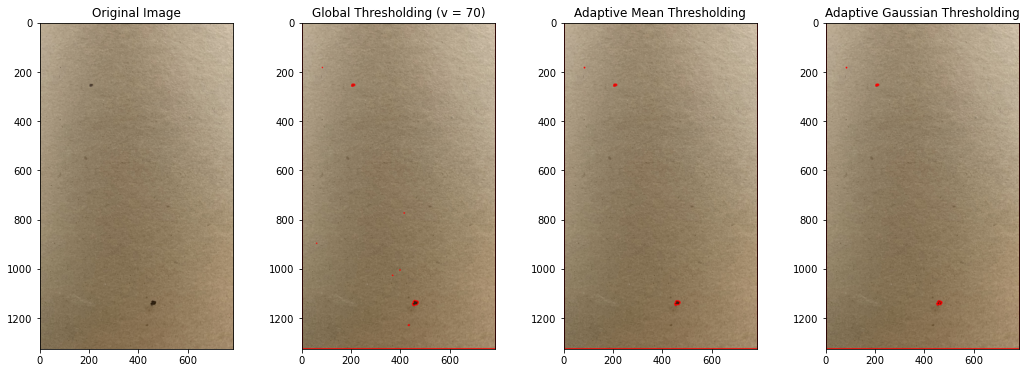

In [95]:
# black spot
img = cv2.imread('blackspot.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# cv2.threshold(image, thresh, max, method) 
v = 70
ret,th1 = cv2.threshold(gray_img ,v ,255,cv2.THRESH_BINARY)
c1, h1 = cv2.findContours(th1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

# cv2.adaptiveThreshold(src, maxval, thresh_type, type, Block Size, C)
th2 = cv2.adaptiveThreshold(gray_img ,255, 
                            cv2.ADAPTIVE_THRESH_MEAN_C, 
                            cv2.THRESH_BINARY, 
                            blockSize = 151, 
                            C = 70)
c2, h2 = cv2.findContours(th2,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  

th3 = cv2.adaptiveThreshold(gray_img ,255, 
                            cv2.cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                            cv2.cv2.THRESH_BINARY, 
                            blockSize = 151, 
                            C = 70)
c3, h3 = cv2.findContours(th3,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  


titles = ['Original Image', 'Global Thresholding (v = {})'.format(v),
          'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images =   [img, th1, th2, th3]
contours = [list(), c1, c2, c3]

fig = plt.figure(num=1, figsize=[18,6])

plt.title(titles[0])    
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


for ii in range(4):   
    plt.subplot(1,4,ii + 1)
    plt.title(titles[ii]) 
    plt.imshow(cv2.drawContours(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), contours[ii],-1,(255,0,0),3))

# now = time.strftime("%Y%m%d%H%M%S")
# fig.savefig('defectDetection_{}.jpg'.format(now), dpi= 400)

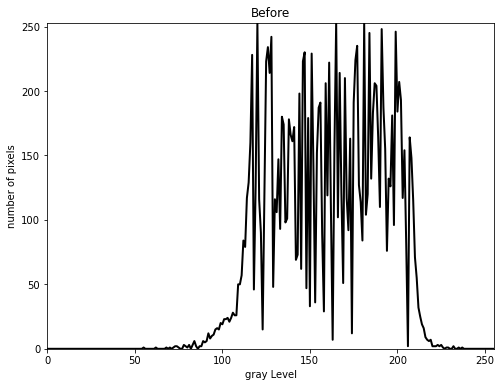

In [103]:
img = cv2.imread('blob_1.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Calculate the gray level distribution
fig = plt.figure(num=2, figsize=[8,6])
calcGrayHist(gray_img, "Before")
fig.savefig('calcGrayHist_Before.jpg', dpi= 400)
# modi_gray_img = contrast_brightness_image(gray_img, 2, 3)
# calcGrayHist(modi_gray_img, "After")

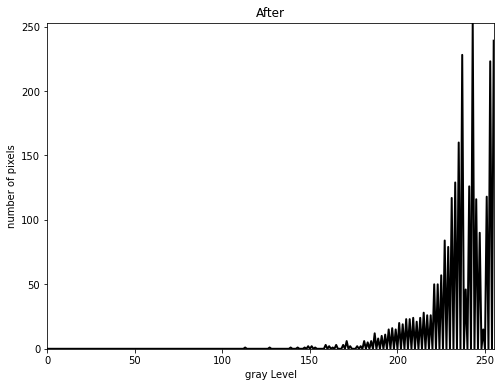

In [104]:
fig = plt.figure(num=2, figsize=[8,6])
modi_gray_img = contrast_brightness_image(gray_img, 2, 3)
calcGrayHist(modi_gray_img, "After")
fig.savefig('calcGrayHist_After.jpg', dpi= 400)

D:\PythonProgm\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


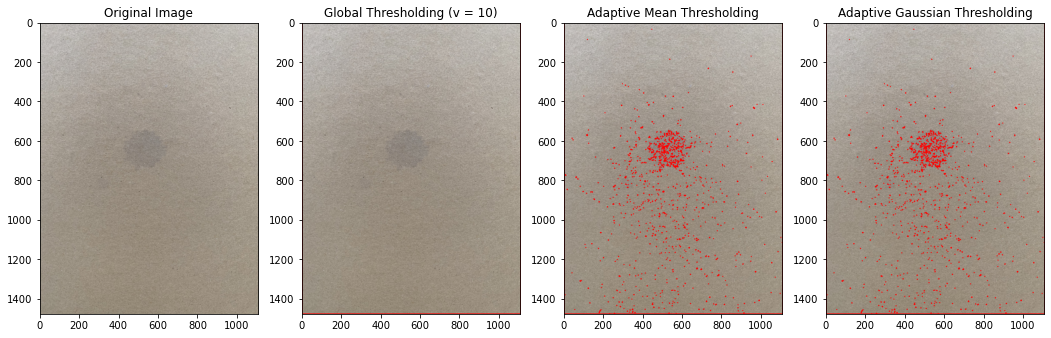

In [97]:
# cv2.threshold(image, thresh, max, method) 
v = 10
ret,th1 = cv2.threshold(modi_gray_img ,v ,255,cv2.THRESH_BINARY)
c1, h1 = cv2.findContours(th1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

# cv2.adaptiveThreshold(src, maxval, thresh_type, type, Block Size, C)
th2 = cv2.adaptiveThreshold(modi_gray_img ,255, 
                            cv2.ADAPTIVE_THRESH_MEAN_C, 
                            cv2.THRESH_BINARY, 
                            blockSize = 151, 
                            C = 10)
c2, h2 = cv2.findContours(th2,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  

th3 = cv2.adaptiveThreshold(modi_gray_img ,255, 
                            cv2.cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                            cv2.cv2.THRESH_BINARY, 
                            blockSize = 151, 
                            C = 10)
c3, h3 = cv2.findContours(th3,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  


titles = ['Original Image', 'Global Thresholding (v = {})'.format(v),
          'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images =   [img, th1, th2, th3]
contours = [list(), c1, c2, c3]

fig = plt.figure(num=1, figsize=[18,6])

plt.title(titles[0])    
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


for ii in range(4):   
    plt.subplot(1,4,ii + 1)
    plt.title(titles[ii]) 
    plt.imshow(cv2.drawContours(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), contours[ii],-1,(255,0,0),3))

now = time.strftime("%Y%m%d%H%M%S")
fig.savefig('defectDetection_{}.jpg'.format(now), dpi= 400)